<CENTER><img src="../images/ATLASOD.gif" style="width:50%"></CENTER>

# <CENTER><h1> Analysis of $H \rightarrow ZZ$ process. Rediscovering the Higgs boson by yourself</h1></CENTER>

## Simple pyROOT notebook example
<p> In this notebook you can find an easy set of commands that show the basic computing techniques commonly used in high energy  physics (HEP) analysis. It also shows how to create a histogram, fills it, draws it and uses a fit function on it. Moreover it is an introduction to [ROOT](https://root.cern.ch/) too. At the end you will get a plot with the invariant mass of the four leptons system, which represents the invariant mass of the Z boson.</p>

<p> The Analysis is implemented by using some useful tools, such as pandas (to storage dataframes), numpy (the numerical library of python), uproot3 (to read root files), matplotlib (to plot our graphics) and math library (an additional library in python that allows you to use numerical functions).

First at all, we should verify that we have installed all need tools to perform our analysis. If we haven't, we can run the next code line:

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

Now, we can import the tools that we are going to use (pandas, numpy, matplotlib, etc):

In [1]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import time # to measure time to analyse
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


The root file which contains the events information is storaged in [4lep folder](https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/). So we are going to define the "path_file" variable which contains the url and the name of the root file. The next code line also define a variable named "lumi", which represents the luminosity and it is equal to 10 $fb^{-1}$. If we want to run the analysis over a fraction of the whole data and MC samples, we can define another variable named "fraction", which will be defined equal to 1.0 as default. However, you can change this fraction value and see how this can affect the final result shown in the final plot:

In [2]:
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" ## for local folder, but you have to download all root files used in this analysis 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address

Now, we are going to make a list named "samples". In this samples list we are going to include data and background samples (including the signal we want to observe). In the next code line we can see all samples that are going to be used in the analysis and to what group they belong. If you want to add more samples, consider modify this code line too. 

In [3]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r'Background $Z,t\bar{t}$' : { # Z + ttbar
        'list' : ['Zee','Zmumu','ttbar_lep'],
        'color' : "#6b59d3" # purple
    },

    r'Background $ZZ^*$' : { # ZZ
        'list' : ['llll'],
        'color' : "#ff0000" # red
    },
    
    
    r'Signal ($m_H$ = 125 GeV)' : { # H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#00cdff" # light blue
    },
}

The next function named "get data from files" return the events from data and MC samples that passed the selection criteria once we have applied all cuts. First, the function makes a for loop in the "samples" list and separates data from background in order to define an adequate path to open the root files. Then, it defines a temporary dataframe in which we save the events passing the criteria selection for each sample. Finally, it adds these temporary dataframes into a dictionary (named "data" in the next code line) for each sample group and returns this data dictionary with the information of all the events considered in the analysis that passed the criteria selection. At the end, this fucntion gives us the whole events information we need to create our final plot.

In [4]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
            #print(temp['lep_pt'])
            #print(temp['mllll'])
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

The "calc_weight" function calculates the total weight for each event taking into account the weight associated with the cross section and the efficiency of the detectors, the scale factors that consider the PILE UP and leptons triggers and the weight given by the algorithms used to create the MC samples. This function is only applied for MC samples and not for data.

In [5]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight*mcWeight*scaleFactor_PILEUP*scaleFactor_ELE*scaleFactor_MUON*scaleFactor_LepTRIGGER)

Now, we define a function that computes the factor weight due to the information in the infofile.py file. This function uses the event weight due to efficiency of the calorimeters, the sum of weights for MC and the cross section for samples. Of course, the data samples are not needed to be scaled, this only apply for MC samples:

In [6]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

The function that computes the mass of the four lepton system is defined below. It is needed the pT, $\eta$, $\phi$ and the energy of each lepton in order to get the invariant mass.

In [7]:
def calc_mllll(lep_pt, lep_eta, lep_phi, lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lepton[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lepton[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lepton[2] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lepton[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lepton[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lepton[3] momentum    
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

## Changing a cut

For this analysis, we only apply two main cuts. These cuts are going to be defined as follow:

### Lepton charge cut

This cut selects events in which the sum of the four lepton's charge is equal to zero. This is because the Z boson has an electric charge equal to zero and therefore, Z boson decays into two leptons of opposite charges. The events that fulfill this requirements returns True.

In [8]:
def cut_lep_charge(lep_charge):     
    return lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] == 0

### Lepton type cut

This cut needs the lepton type of each lepton, because we want to choose events that have two pairs of electrons, two pairs of muons or one pair of electrons and one pair of muons in the final state. If the event doesn't fulfill this requirement, the event is dropped.

In [9]:
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    return (sum_lep_type == 44) or (sum_lep_type == 48) or (sum_lep_type == 52)

## Applying a cut

Now, we can define a function that applies all cuts and the criteria selection. For this reason, we create a function named "read_file" that receives a string path and the name of the sample we want to analyze. In this function we print the number of initial events and the number of events that passed the cuts. We also compute the invariant mass of the four lepton system and save it in a column into the dataframe which contains all the selected events for each batch. At the end, it returns a dataframe with the selected events for the sample given as an argument of the function. 

In [10]:
def read_file(path,sample):
    start = time.time() # start the clock
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    for data in tree.iterate(['lep_charge','lep_type','lep_pt',
                              'lep_eta','lep_phi','lep_E', 
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER'], # variables to calculate Monte Carlo weight
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        #print(data[['lep_pt', 'mcWeight']])
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        # cut on lepton charge using the function cut_lep_charge defined above
        data = data[ np.vectorize(cut_lep_charge)(data.lep_charge)]
        
        # cut on lepton type using the function cut_lep_type defined above
        data = data[ np.vectorize(cut_lep_type)(data.lep_type)]        
        
        # calculation of 4-lepton invariant mass using the function calc_mllll defined above
        data['mllll'] = np.vectorize(calc_mllll)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        #data['lep_pt']
        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        #print(data[['lep_pt', 'mllll']])
        elapsed = time.time() - start # time taken to process
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
        
    return data_all # return dataframe containing events passing all cuts

Now, we are ready to perform the analysis. Just run the next line code if you want to save the complete selected events for all samples in a dictionary of dataframe called "data". We will use this dictionary of dataframes to plot our final graph. 

In [11]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing data samples
	Processing: data_A
		 nIn: 39,	 nOut: 	27	 in 0.3s
	Processing: data_B
		 nIn: 156,	 nOut: 	86	 in 0.2s
	Processing: data_C
		 nIn: 237,	 nOut: 	146	 in 0.3s
	Processing: data_D
		 nIn: 400,	 nOut: 	248	 in 0.3s
Processing Background $Z,t\bar{t}$ samples
	Processing: Zee
		 nIn: 898,	 nOut: 	243	 in 0.5s
	Processing: Zmumu
		 nIn: 684,	 nOut: 	257	 in 0.4s
	Processing: ttbar_lep
		 nIn: 1031,	 nOut: 	334	 in 0.6s
Processing Background $ZZ^*$ samples
	Processing: llll
		 nIn: 106415,	 nOut: 	100522	 in 21.0s
		 nIn: 106415,	 nOut: 	100595	 in 29.2s
		 nIn: 106415,	 nOut: 	100580	 in 38.9s
		 nIn: 106415,	 nOut: 	100618	 in 46.3s
		 nIn: 106415,	 nOut: 	100655	 in 53.9s
		 nIn: 22204,	 nOut: 	20987	 in 55.7s
Processing Signal ($m_H$ = 125 GeV) samples
	Processing: ggH125_ZZ4lep
		 nIn: 104555,	 nOut: 	102484	 in 32.6s
		 nIn: 60161,	 nOut: 	58967	 in 36.8s
	Processing: VBFH125_ZZ4lep
		 nIn: 102038,	 nOut: 	99807	 in 30.5s
		 nIn: 89088,	 nOut: 	87063	 in 37.5s
	

Finally, we define a function that plots our final graphic. This function receives the data dictionary with the information of all selected events in our analysis and create histograms for each dataframe (which are the main sources of background, the signal and the data). The final plot is saved in a pdf file into the folder called "plots".

In [12]:
def plot_data(data):
    GeV = 1.0
    xmin = 80 * GeV
    xmax = 250 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['mllll'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    signal_x = data[r'Signal ($m_H$ = 125 GeV)']['mllll'] # histogram the signal
    signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Signal ($m_H$ = 125 GeV)']: # if not data nor signal
            mc_x.append( data[s]['mllll'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    plt.savefig('plots/HZZ_m4L.pdf')
    return

Run the next line code if you want to see the final plot with the invariant mass of the Z boson.

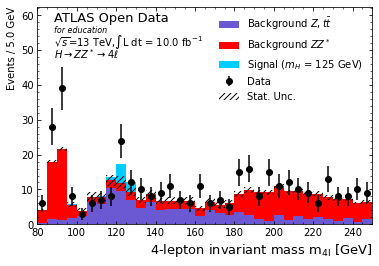

In [13]:
plot_data(data)